In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import io

from pathlib import Path

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

## Preprocessing

In [3]:
#path = Path('datasets/stocks/mbb.csv')
path = Path('mbb.csv')

dataset = pd.read_csv(path, parse_dates=True)
df = dataset.copy()
df.rename(index=str, columns={"Price":"Close"}, inplace=True)
df.head(10)

# Convert the date column
df['Date'] = pd.to_datetime(df['Date'])

df.sort_values(by=['Date'], ascending=True, inplace=True)
df.set_index(['Date'], inplace=True)    
display(df.head(10))
df.info()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-09-02,8.72,9.00,9.00,8.69,12.92M,0.00%
2011-09-05,8.73,8.72,8.75,8.70,12.39M,0.11%
2011-09-06,8.68,8.72,8.72,8.68,11.48M,-0.57%
2011-09-07,8.67,8.70,8.70,8.64,5.73M,-0.12%
2011-09-08,8.69,8.71,8.74,8.67,4.69M,0.23%
2011-09-09,8.69,8.70,8.70,8.68,5.09M,0.00%
2011-09-12,8.61,8.65,8.68,8.55,8.59M,-0.92%
2011-09-13,8.60,8.58,8.61,8.55,3.62M,-0.12%
2011-09-14,8.60,8.64,8.64,8.57,10.24M,0.00%


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1893 entries, 2011-09-02 to 2019-05-24
Data columns (total 6 columns):
Close       1893 non-null float64
Open        1893 non-null float64
High        1893 non-null float64
Low         1893 non-null float64
Vol.        1893 non-null object
Change %    1893 non-null object
dtypes: float64(4), object(2)
memory usage: 103.5+ KB


In [4]:
df.isna().any()

Close       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

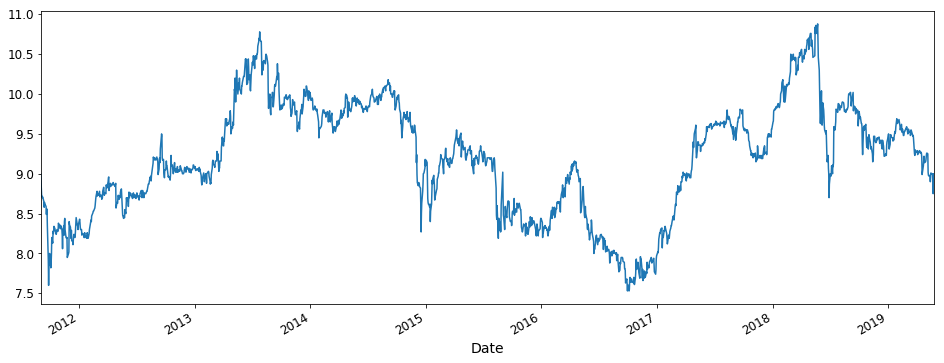

In [5]:
df['Open'].plot(figsize=(16,6))

### 7 days rolling means

In [6]:
df = df[['Close', 'Open', 'High', 'Low']]
df.rolling(7).mean().head(8)

,Close,Open,High,Low
Date,,,,
2011-09-02,NaN,NaN,NaN,NaN
2011-09-05,NaN,NaN,NaN,NaN
2011-09-06,NaN,NaN,NaN,NaN
2011-09-07,NaN,NaN,NaN,NaN
2011-09-08,NaN,NaN,NaN,NaN
2011-09-09,NaN,NaN,NaN,NaN
2011-09-12,8.684286,8.742857,8.755714,8.658571
2011-09-13,8.667143,8.682857,8.700000,8.638571


In [7]:
df.head(3)

,Close,Open,High,Low
Date,,,,
2011-09-02,8.72,9.00,9.00,8.69
2011-09-05,8.73,8.72,8.75,8.70
2011-09-06,8.68,8.72,8.72,8.68


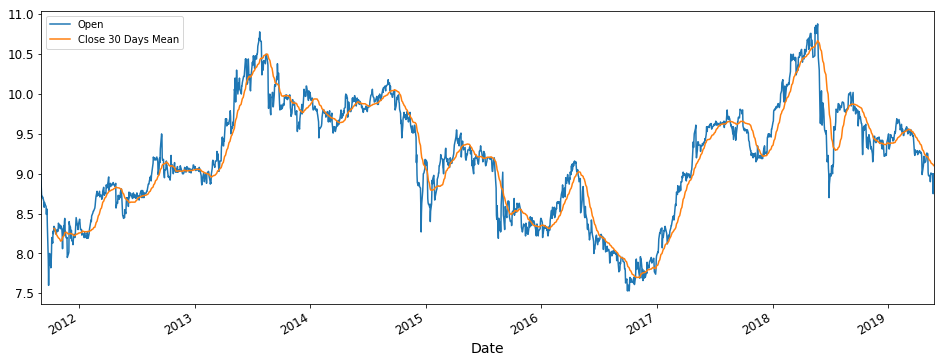

In [8]:
# Open vs Close 30 days mean
df['Close 30 Days Mean'] = df['Close'].rolling(window=30).mean()
df[['Open', 'Close 30 Days Mean']].plot(figsize=(16,6))
#df.rolling(window=30).mean()['Close'].plot()

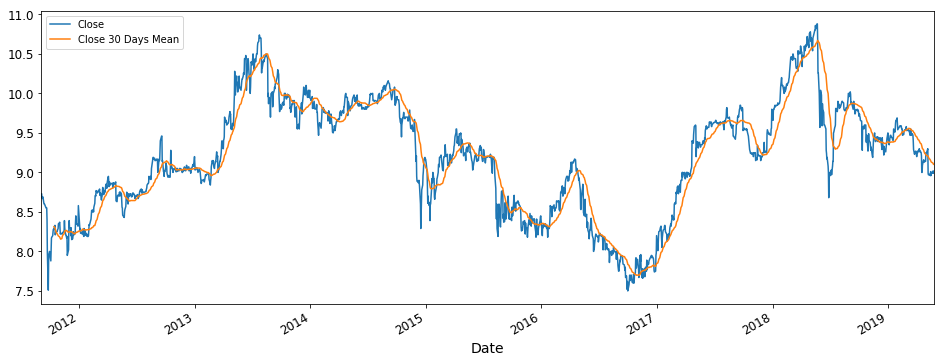

In [9]:
# df['Close: 30 Day Mean'] = df['Price'].rolling(window=30).mean()
df[['Close','Close 30 Days Mean']].plot(figsize=(16,6))

### Expanding

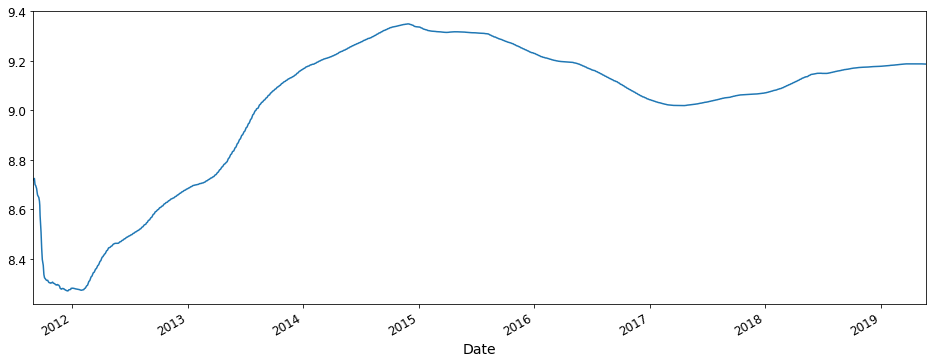

In [10]:
# Optional specify a minimum number of periods
df['Close'].expanding(min_periods=1).mean().plot(figsize=(16,6))

### Group into X days prices

In [11]:
df_temp = df.copy()
df_temp.reset_index(inplace=True)
number_of_days = 5
df_temp.head(5)

,Date,Close,Open,High,Low,Close 30 Days Mean
0,2011-09-02,8.72,9.00,9.00,8.69,NaN
1,2011-09-05,8.73,8.72,8.75,8.70,NaN
2,2011-09-06,8.68,8.72,8.72,8.68,NaN
3,2011-09-07,8.67,8.70,8.70,8.64,NaN
4,2011-09-08,8.69,8.71,8.74,8.67,NaN


In [12]:
df_temp['GroupId'] = df_temp.index
df_temp['GroupId'] = df_temp.apply(lambda x: df_temp['GroupId'] // number_of_days)
df_grouped_mean = df_temp.groupby(['GroupId'], as_index=False).mean()
display(df.head(10), len(df))
display(df_grouped_mean.head(10), len(df_grouped_mean))

,Close,Open,High,Low,Close 30 Days Mean
Date,,,,,
2011-09-02,8.72,9.00,9.00,8.69,NaN
2011-09-05,8.73,8.72,8.75,8.70,NaN
2011-09-06,8.68,8.72,8.72,8.68,NaN
2011-09-07,8.67,8.70,8.70,8.64,NaN
2011-09-08,8.69,8.71,8.74,8.67,NaN
2011-09-09,8.69,8.70,8.70,8.68,NaN
2011-09-12,8.61,8.65,8.68,8.55,NaN
2011-09-13,8.60,8.58,8.61,8.55,NaN
2011-09-14,8.60,8.64,8.64,8.57,NaN


1893

,GroupId,Close,Open,High,Low,Close 30 Days Mean
0,0,8.698,8.770,8.782,8.676,NaN
1,1,8.618,8.638,8.650,8.584,NaN
2,2,8.408,8.508,8.526,8.352,NaN
3,3,7.866,7.856,7.996,7.698,NaN
4,4,8.030,7.972,8.086,7.906,NaN
5,5,8.260,8.256,8.300,8.212,8.313333
6,6,8.254,8.272,8.300,8.218,8.269000
7,7,8.304,8.318,8.358,8.278,8.204533
8,8,8.264,8.330,8.338,8.232,8.166467
9,9,8.244,8.230,8.282,8.178,8.207333


379

### Split to train and test data sets

In [13]:
df = df_grouped_mean

from sklearn.model_selection import train_test_split
training_set, test_set = train_test_split(df, test_size=0.20, shuffle=False)
display(len(training_set),training_set.head(10))
display(len(test_set), test_set.head(10))

303

,GroupId,Close,Open,High,Low,Close 30 Days Mean
0,0,8.698,8.770,8.782,8.676,NaN
1,1,8.618,8.638,8.650,8.584,NaN
2,2,8.408,8.508,8.526,8.352,NaN
3,3,7.866,7.856,7.996,7.698,NaN
4,4,8.030,7.972,8.086,7.906,NaN
5,5,8.260,8.256,8.300,8.212,8.313333
6,6,8.254,8.272,8.300,8.218,8.269000
7,7,8.304,8.318,8.358,8.278,8.204533
8,8,8.264,8.330,8.338,8.232,8.166467
9,9,8.244,8.230,8.282,8.178,8.207333


76

,GroupId,Close,Open,High,Low,Close 30 Days Mean
303,303,9.210,9.224,9.248,9.186,9.423667
304,304,9.220,9.238,9.346,9.152,9.340333
305,305,9.212,9.208,9.238,9.196,9.286067
306,306,9.200,9.204,9.230,9.166,9.233933
307,307,9.286,9.286,9.360,9.238,9.224533
308,308,9.356,9.294,9.396,9.274,9.233733
309,309,9.490,9.488,9.510,9.436,9.273933
310,310,9.608,9.544,9.632,9.504,9.329333
311,311,9.812,9.772,9.824,9.764,9.417533
312,312,9.846,9.834,9.862,9.824,9.524400


## Training

In [14]:
training_set=training_set['Open']
training_set=pd.DataFrame(training_set)
display(training_set.head(10))

,Open
0,8.770
1,8.638
2,8.508
3,7.856
4,7.972
5,8.256
6,8.272
7,8.318
8,8.330
9,8.230


In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [16]:
# Creating a data structure with 30 timesteps and 1 output
TIME_STEP=30
X_train = []
y_train = []
for i in range(TIME_STEP, len(training_set)):
    X_train.append(training_set_scaled[i-TIME_STEP:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
display(X_train.shape)

(273, 30, 1)

### LSTM network

In [17]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [18]:
# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
273/273 [==============================] - 6s 21ms/step - loss: 0.1565
Epoch 2/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0484
Epoch 3/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0328
Epoch 4/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0295
Epoch 5/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0260
Epoch 6/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0256
Epoch 7/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0248
Epoch 8/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0231
Epoch 9/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0221
Epoch 10/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0204
Epoch 11/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0211
Epoch 12/100
273/273 [=========================

In [0]:
test_set=test_set['Open']
test_set=pd.DataFrame(test_set)

In [22]:
display(test_set.info())
display(test_set.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 303 to 378
Data columns (total 1 columns):
Open    76 non-null float64
dtypes: float64(1)
memory usage: 1.2 KB


None

,Open
303,9.224
304,9.238
305,9.208
306,9.204
307,9.286
308,9.294
309,9.488
310,9.544
311,9.772
312,9.834


In [0]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_set)

In [24]:
test_set_scaled=pd.DataFrame(test_set_scaled)
test_set_scaled.head()

,0
0,0.162496
1,0.169898
2,0.154036
3,0.151921
4,0.195277


30
(50, 30, 1)
(50, 1)


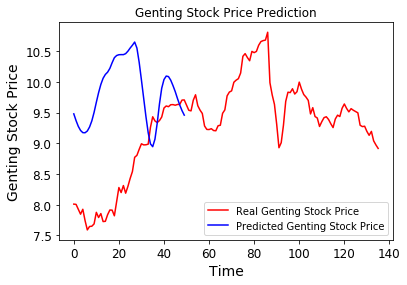

In [29]:
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - TIME_STEP:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(TIME_STEP, 80):
    X_test.append(inputs[i-TIME_STEP:i, 0])
print(len(X_test[0]))
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(X_test.shape)
print(predicted_stock_price.shape)

inputs = dataset_total[len(dataset_total) - len(test_set) - TIME_STEP:].values
inputs = inputs.reshape(-1,1)
real_stock_price = []
for i in range(TIME_STEP, 80):
    real_stock_price.append(inputs[i-TIME_STEP:i, 0])    
real_stock_prices = np.array(real_stock_price)
#print(real_stock_price)

#print(predicted_stock_price.shape)
#print(real_stock_prices.shape)
real_stock_prices = dataset_total[len(dataset_total) - len(test_set) - 60:].values
real_stock_prices = real_stock_prices.reshape(-1,1)
#print(len(real_stock_prices))
#print(len(predicted_stock_price))

# Visualising the results
plt.plot(real_stock_prices, color = 'red', label = 'Real Genting Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Genting Stock Price')
plt.title('Genting Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Genting Stock Price')
plt.legend()
plt.show()
#print(predicted_stock_price)
#print(test_set)